In [68]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score,recall_score

In [52]:
# import numpy as np

# # Replace 'your_file.csv' with your actual CSV file path
# train = np.loadtxt('train.csv', delimiter=',', skiprows=1)  # skiprows if there's a header
# data_modified = np.delete(train, 0, axis=1)

In [53]:
train=pd.read_csv("train.csv")
# test=pd.read_csv('test.csv')
x=train.drop(['rainfall','id'],axis=1).copy()
y=train['rainfall']
x.head(10)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8
5,6,1022.7,20.6,18.6,16.5,12.5,79.0,81.0,0.0,20.0,15.7
6,7,1022.8,19.5,18.4,15.3,11.3,56.0,46.0,7.6,20.0,28.4
7,8,1019.7,15.8,13.6,12.7,11.8,96.0,100.0,0.0,50.0,52.8
8,9,1017.4,17.6,16.5,15.6,12.5,86.0,100.0,0.0,50.0,37.5
9,10,1025.4,16.5,14.4,12.0,8.6,77.0,84.0,1.0,50.0,38.3


In [54]:

SPLIT_TIME=1752
def train_val_split(time, x,y):
    """ Splits time series into train and validations sets"""
    ttr = time[:SPLIT_TIME]
    tte = time[SPLIT_TIME:]
    xtr = x[:SPLIT_TIME]
    xte = x[SPLIT_TIME:]
    ytr = y[:SPLIT_TIME]
    yte = y[SPLIT_TIME:]

    return ttr,tte,xtr,xte,ytr,yte


In [55]:
# def windowed_dataset(series, window_size,batch_size,shuffle_buffer_size):
#     """Creates windowed dataset"""
#     series = tf.expand_dims(series, axis=-1)
#     dataset = tf.data.Dataset.from_tensor_slices(series)
#     dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#     if shuffle_buffer_size != None:
#       dataset = dataset.shuffle(shuffle_buffer_size)
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     dataset = dataset.batch(batch_size).prefetch(1)
#     return dataset

# window_size = 4
# batch_size = 4
# shuffle_buffer_size = 2
# train_set = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
# count=0
# for i in train_set:
#   print(i)
#   count+=1
#   if count ==5:
#     break


In [56]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [57]:
ttr,tte,xtr,xte,ytr,yte = train_val_split(x['day'],x.drop(columns='day').copy(),y)

xtr = scaler.fit_transform(xtr)
# xva = scaler.transform(xva)
xte = scaler.transform(xte)

# Reshape input
xtr = xtr.reshape((xtr.shape[0], 1, xtr.shape[1]))
# X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
xte = xte.reshape((xte.shape[0], 1, xte.shape[1]))

# Define inputs
inputs = Input(shape=(xtr.shape[1], xtr.shape[2]))

In [58]:
!pip install -q -U keras-tuner


In [59]:

from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, GRU
from tensorflow.keras.models import Model
import tensorflow as tf
import keras_tuner as kt

# Model hyperparameters
input_dim =xtr.shape[1]
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 32
epochs = 100
patience = 20



def create_model(hp):
  for i in range(hp.Choice('hidden_layers', values=[1])):
    # First LSTM layer (unidirectional)
    x = LSTM(256, activation='tanh', return_sequences=True)(inputs)
    x = Dropout(rate = hp.Float("units_{}".format(i+1),min_value=0.3,max_value=0.8,step=1))(x)
    # Second LSTM layer
    x = LSTM(128, activation='tanh', return_sequences=True)(x)
    x = Dropout(rate = hp.Float("units_{}".format(i+1),min_value=0.3,max_value=0.8,step=1))(x)

    # Third LSTM layer
    x = LSTM(64, activation='tanh', return_sequences=True)(x)
    x = Dropout(rate = hp.Float("units_{}".format(i+1),min_value=0.3,max_value=0.8,step=1))(x)

    # Fourth LSTM layer (no return_sequences)
    x = LSTM(32, activation='tanh')(x)

    # Additional dense layer
    x = Dense(16, activation='tanh')(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)
    #dropout, loss fn, activation fn, lr
    # Build and compile model
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'])
  return model
# Summary
# model.summary()

In [60]:
seed=45
tuner_hb = kt.Hyperband(
        create_model,
        objective="val_accuracy",
        factor=3,
        max_epochs=20,
        hyperband_iterations=1,
        seed=45,
        directory='my_dir',
        project_name='kt',
        overwrite=True)

# tuner_rs = kt.RandomSearch(
#         create_model,
#         objective="val_accuracy",
#         max_trials=150,
#         seed=seed,
#         directory='my_dir',
#         project_name='kt',
#         overwrite=True)

tuner_bo = kt.BayesianOptimization(
        create_model,
        objective="val_accuracy",
        max_trials=100,
        seed=seed,
        directory='my_dir',
        project_name='kt',
        overwrite=True)

In [62]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=patience//2,
    min_lr=1e-6,
    verbose=1
)

# Train model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )

tuner_hb.search(xtr, ytr,validation_data=(xte, yte), callbacks=[early_stopping ,reduce_lr])

Trial 3 Complete [00h 00m 14s]
val_accuracy: 0.878995418548584

Best val_accuracy So Far: 0.878995418548584
Total elapsed time: 00h 01m 01s


In [64]:
best_hps_hb=tuner_hb.get_best_hyperparameters()[0]
model = tuner_hb.hypermodel.build(best_hps_hb)
history = model.fit(xtr, ytr, epochs=100, validation_data=(xte, yte), callbacks=[early_stopping,reduce_lr])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))



Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.7439 - loss: 0.6273 - val_accuracy: 0.8630 - val_loss: 0.3400 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8603 - loss: 0.3459 - val_accuracy: 0.8653 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8714 - loss: 0.3245 - val_accuracy: 0.8790 - val_loss: 0.3283 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8785 - loss: 0.3233 - val_accuracy: 0.8767 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8744 - loss: 0.3307 - val_accuracy: 0.8493 - val_loss: 0.3571 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8738 - loss: 0.3224 - val_accuracy: 0.8790 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8714 - loss: 0.3372 -

In [65]:
hypermodel_hb = tuner_hb.hypermodel.build(best_hps_hb)


In [ ]:
model.fit(xtr, ytr, epochs=best_epoch,batch_size=batch_size,validation_data=(xte, yte), callbacks=[early_stopping,reduce_lr])

In [72]:
# Evaluate mode
y_pred = model.predict(xte)

y_pred = y_pred.round()
accuracy = accuracy_score(yte, y_pred)
f1 = f1_score(yte, y_pred)
roc_auc = roc_auc_score(yte, y_pred)
recall=recall_score(yte,y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print('Classification Report:\n', classification_report(yte, y_pred))
print('Confusion Matrix:\n', confusion_matrix(yte, y_pred))


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Accuracy: 0.8721
recall: 0.9393
F1-score: 0.9207
ROC-AUC: 0.7794
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.62      0.67        92
           1       0.90      0.94      0.92       346

    accuracy                           0.87       438
   macro avg       0.82      0.78      0.80       438
weighted avg       0.87      0.87      0.87       438

Confusion Matrix:
 [[ 57  35]
 [ 21 325]]


In [82]:
test_df=pd.read_csv("test.csv")
# Preprocess test data
test_features = test_df.drop(columns=['id','day'], errors='ignore')  # Drop unnecessary columns
test_features = scaler.transform(test_features)
test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))
y_pred = model.predict(test_features)
test_df['rainfall']=y_pred.round()
# Create submission file
submission = test_df[['id', 'rainfall']]  # Include 'id' and the predicted target column
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Submission file created: submission.csv


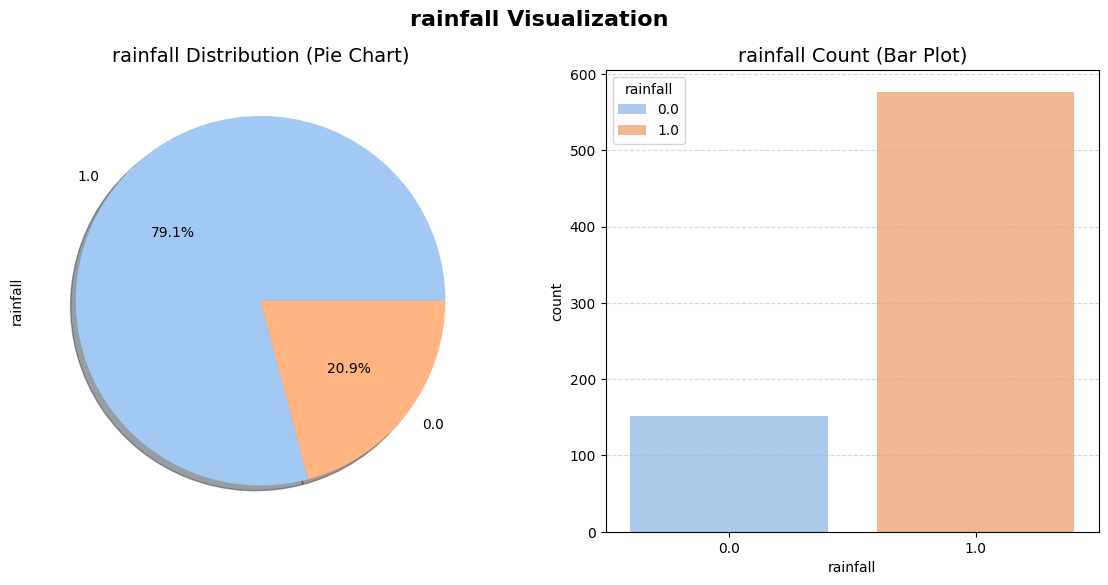

Columns in Target column are: rainfall
1.0    577
0.0    152
Name: count, dtype: int64


In [79]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
def target_plot(column,train):
    custom_palette = sns.color_palette("pastel")
    f, ax = plt.subplots(1, 2, figsize=(14,6))
    train[column].value_counts().plot.pie(autopct='%2.1f%%', ax=ax[0], shadow=True, colors=custom_palette)
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column, data=train, ax=ax[1], palette=custom_palette,hue=column)
    ax[0].set_title(f'{column} Distribution (Pie Chart)', fontsize=14)
    ax[1].set_title(f'{column} Count (Bar Plot)', fontsize=14)
    plt.suptitle(f'{column} Visualization', fontsize=16, fontweight='bold')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print("Columns in Target column are:",train[column].value_counts())
target_plot('rainfall',test_df)

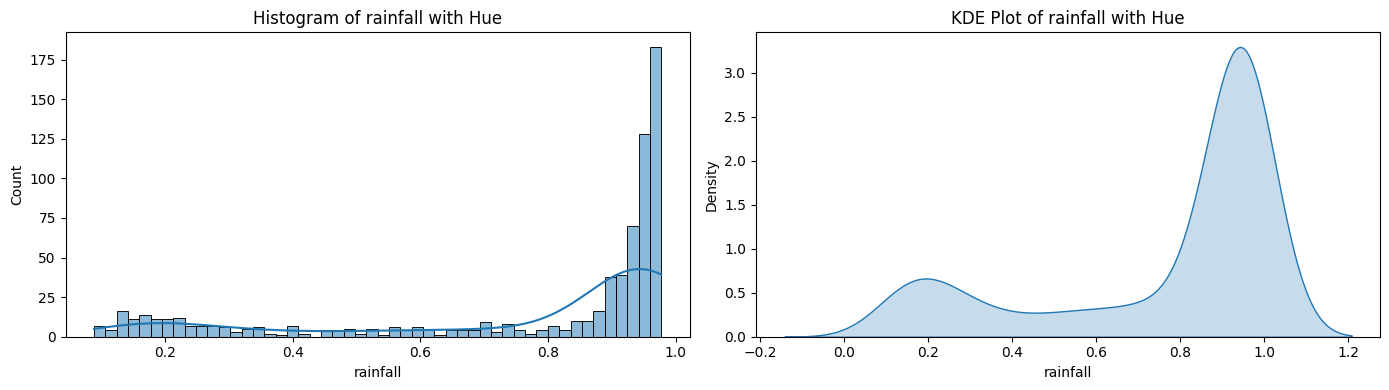

In [81]:
# @title continous feature disturbutions
def target3_plot(column,train,):
      import warnings
      warnings.filterwarnings("ignore")
      hue_columns = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
      fig, axes = plt.subplots(1, 2, figsize=(14, 4))  # Create subplots with 1 row and 2 columns

      # Plot histogram with hue
      sns.histplot(data=train, x=column, hue_order=hue_columns, bins=50, kde=True, ax=axes[0])
      axes[0].set_title(f'Histogram of {column} with Hue')
      axes[0].set_xlabel(column)
      axes[0].set_ylabel('Count')
      # axes[0].legend(title='Fault Types', loc='upper right',fontsize="x-large")

      # Plot KDE plot with hue
      sns.kdeplot(data=train, x=column, shade=True,hue_order=hue_columns, ax=axes[1])
      axes[1].set_title(f'KDE Plot of {column} with Hue')
      axes[1].set_xlabel(column)
      axes[1].set_ylabel('Density')
      # axes[1].legend(title='Fault Types', loc='upper right',fontsize="x-large")

      plt.tight_layout()  # Adjust spacing between subplots
      plt.show()
target3_plot('rainfall',test_df)